# **STEP 1 | IMPORTING LIBRARIES & DATASET**

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, f1_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

In [48]:
df = pd.read_csv("/content/drive/MyDrive/Dataset/Vehicle Collision.csv", encoding = "latin1")

# **STEP 2 | INSPECT TARGET COLUMN VALUES**

In [49]:
print("Unique values in PERSON_INJURY:")
print(df["PERSON_INJURY"].value_counts())

print("\nPercentage distribution:")
print(df["PERSON_INJURY"].value_counts(normalize=True) * 100)

Unique values in PERSON_INJURY:
PERSON_INJURY
Injured    229633
Killed       1023
Name: count, dtype: int64

Percentage distribution:
PERSON_INJURY
Injured    99.556482
Killed      0.443518
Name: proportion, dtype: float64


# **STEP 3 | INITIAL DATA INSPECTION & SUMMARY STATISTICS**

In [50]:
# STEP 3.1 | Dataset shape

print("Shape of dataset (rows, columns):", df.shape)

Shape of dataset (rows, columns): (230660, 21)


In [51]:
# STEP 3.2 | Dataset info

print("\n--- DATASET INFO ---")
df.info()


--- DATASET INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230660 entries, 0 to 230659
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   UNIQUE_ID              230660 non-null  object 
 1   COLLISION_ID           230656 non-null  float64
 2   CRASH_DATE             230656 non-null  object 
 3   CRASH_TIME             230656 non-null  object 
 4   PERSON_ID              230653 non-null  object 
 5   PERSON_TYPE            230656 non-null  object 
 6   PERSON_INJURY          230656 non-null  object 
 7   VEHICLE_ID             181937 non-null  float64
 8   PERSON_AGE             229663 non-null  float64
 9   EJECTION               102787 non-null  object 
 10  EMOTIONAL_STATUS       126918 non-null  object 
 11  BODILY_INJURY          126959 non-null  object 
 12  POSITION_IN_VEHICLE    102906 non-null  object 
 13  SAFETY_EQUIPMENT       90120 non-null   object 
 14  PED_LOCATION  

In [52]:
# STEP 3.3 | Numerical summary statistics

print("\n--- SUMMARY STATISTICS (NUMERICAL) ---")
df.describe().T


--- SUMMARY STATISTICS (NUMERICAL) ---


,count,mean,std,min,25%,50%,75%,max
COLLISION_ID,230656.0,2.824113e+06,1.497211e+06,39.0,2812695.0,3474966.5,3873819.25,4695378.0
VEHICLE_ID,181937.0,1.567930e+07,3.051295e+06,602947.0,13535225.0,17145743.0,17959965.00,20585753.0
PERSON_AGE,229663.0,3.647403e+01,8.492469e+01,-997.0,23.0,33.0,49.00,9999.0


In [53]:
# STEP 3.4 | Categorical columns & top values

cat_cols = df.select_dtypes(include="object").columns

print("Categorical Columns:")
print(cat_cols)

for col in cat_cols:
    print(f"\n--- {col} (Top 5 values) ---")
    print(df[col].value_counts().head())

Categorical Columns:
Index(['UNIQUE_ID', 'CRASH_DATE', 'CRASH_TIME', 'PERSON_ID', 'PERSON_TYPE',
       'PERSON_INJURY', 'EJECTION', 'EMOTIONAL_STATUS', 'BODILY_INJURY',
       'POSITION_IN_VEHICLE', 'SAFETY_EQUIPMENT', 'PED_LOCATION', 'PED_ACTION',
       'COMPLAINT', 'PED_ROLE', 'CONTRIBUTING_FACTOR_1',
       'CONTRIBUTING_FACTOR_2', 'PERSON_SEX'],
      dtype='object')

--- UNIQUE_ID (Top 5 values) ---
UNIQUE_ID
}           1
10253606    1
10248708    1
10254556    1
7298276     1
Name: count, dtype: int64

--- CRASH_DATE (Top 5 values) ---
CRASH_DATE
10/31/2019    202
11/01/2019    197
10/26/2019    187
10/29/2019    179
10/28/2019    168
Name: count, dtype: int64

--- CRASH_TIME (Top 5 values) ---
CRASH_TIME
17:00    2847
16:00    2846
15:00    2750
18:00    2722
19:00    2274
Name: count, dtype: int64

--- PERSON_ID (Top 5 values) ---
PERSON_ID
1    75968
2    16882
3     6172
4     2478
5     1056
Name: count, dtype: int64

--- PERSON_TYPE (Top 5 values) ---
PERSON_TYPE
Occupan

In [54]:
# STEP 3.5 | Missing values

missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100

missing_df = pd.DataFrame({
    "Missing_Count": missing,
    "Missing_Percentage": missing_pct
}).sort_values("Missing_Count", ascending=False)

print("\n--- MISSING VALUES SUMMARY ---")
missing_df[missing_df["Missing_Count"] > 0]


--- MISSING VALUES SUMMARY ---


,Missing_Count,Missing_Percentage
CONTRIBUTING_FACTOR_2,205477,89.082199
CONTRIBUTING_FACTOR_1,205452,89.071360
PED_ACTION,204430,88.628284
PED_LOCATION,204368,88.601405
SAFETY_EQUIPMENT,140540,60.929507
EJECTION,127873,55.437874
POSITION_IN_VEHICLE,127754,55.386283
PERSON_SEX,103768,44.987427
EMOTIONAL_STATUS,103742,44.976155
BODILY_INJURY,103701,44.958380


In [55]:
# STEP 3.6 | Duplicate rows

print("\nNumber of duplicate rows:", df.duplicated().sum())


Number of duplicate rows: 0


# **STEP 4 | DATA CLEANING IMPLEMENTATION**

In [56]:
# STEP 4 | Data Cleaning & Quality Checks

df_clean = df.copy()

# Keeping only valid target classes
df_clean = df_clean[df_clean["PERSON_INJURY"].isin(["Injured", "Killed"])]

# Binary encoding
df_clean["TARGET_SEVERITY"] = df_clean["PERSON_INJURY"].map({
    "Injured": 0,
    "Killed": 1
})

# Handling invalid ages
df_clean["PERSON_AGE"] = df_clean["PERSON_AGE"].where(
    (df_clean["PERSON_AGE"] >= 0) & (df_clean["PERSON_AGE"] <= 100)
)

# Droping extremely high-missing columns (>85%)
high_missing_cols = [
    "CONTRIBUTING_FACTOR_1",
    "CONTRIBUTING_FACTOR_2",
    "PED_LOCATION",
    "PED_ACTION"
]

df_clean.drop(columns=high_missing_cols, inplace=True)

# Filling moderate-missing categorical columns
fill_unknown_cols = [
    "EJECTION",
    "EMOTIONAL_STATUS",
    "BODILY_INJURY",
    "POSITION_IN_VEHICLE",
    "SAFETY_EQUIPMENT",
    "COMPLAINT",
    "PED_ROLE",
    "PERSON_SEX"
]

for col in fill_unknown_cols:
    df_clean[col] = df_clean[col].fillna("Unknown")

# Droping identifier & leakage columns
id_cols = [
    "UNIQUE_ID",
    "PERSON_ID",
    "VEHICLE_ID",
    "COLLISION_ID"
]

df_clean.drop(columns=id_cols, inplace=True)

# Droping remaining rows with critical nulls
df_clean.dropna(subset=["CRASH_DATE", "CRASH_TIME", "PERSON_TYPE"], inplace=True)

print("✅ Data Cleaning Completed")
print("Final cleaned shape:", df_clean.shape)

✅ Data Cleaning Completed
Final cleaned shape: (230656, 14)


# **STEP 5 | FEATURE ENGINEERING**

In [57]:
# STEP 5 | Feature Engineering (FIXED & ROBUST)

df_fe = df_clean.copy()

# 1. Date & Time Features

# Convert crash date
df_fe["CRASH_DATE"] = pd.to_datetime(df_fe["CRASH_DATE"], errors="coerce")

# Convert crash time safely
df_fe["CRASH_TIME_PARSED"] = pd.to_datetime(
    df_fe["CRASH_TIME"], format="%H:%M", errors="coerce"
)

# Extract hour
df_fe["CRASH_HOUR"] = df_fe["CRASH_TIME_PARSED"].dt.hour

# Drop rows where time could not be parsed
df_fe = df_fe.dropna(subset=["CRASH_HOUR"])

df_fe["CRASH_HOUR"] = df_fe["CRASH_HOUR"].astype(int)

# Day of week & weekend
df_fe["DAY_OF_WEEK"] = df_fe["CRASH_DATE"].dt.dayofweek
df_fe["IS_WEEKEND"] = df_fe["DAY_OF_WEEK"].isin([5, 6]).astype(int)

# Rush hour (morning + evening)
df_fe["IS_RUSH_HOUR"] = (
    df_fe["CRASH_HOUR"].between(7, 9) |
    df_fe["CRASH_HOUR"].between(16, 19)
).astype(int)

# Night accidents
df_fe["IS_NIGHT"] = (
    (df_fe["CRASH_HOUR"] >= 22) |
    (df_fe["CRASH_HOUR"] <= 5)
).astype(int)

# 2. Age Risk Bands

df_fe["AGE_GROUP"] = pd.cut(
    df_fe["PERSON_AGE"],
    bins=[0, 17, 40, 65, 120],
    labels=["Child", "Young_Adult", "Adult", "Senior"]
)

df_fe["AGE_GROUP"] = df_fe["AGE_GROUP"].astype("category")

# 3️. Vulnerability Encoding

df_fe["IS_PEDESTRIAN"] = (df_fe["PERSON_TYPE"] == "Pedestrian").astype(int)
df_fe["IS_BICYCLIST"] = (df_fe["PERSON_TYPE"] == "Bicyclist").astype(int)

# 4️. Safety Risk Features

df_fe["NO_SAFETY_EQUIPMENT"] = df_fe["SAFETY_EQUIPMENT"].isin(
    ["None", "Unknown"]
).astype(int)

df_fe["EJECTION_RISK"] = df_fe["EJECTION"].isin(
    ["Ejected", "Partially Ejected"]
).astype(int)

# 5️. Final Cleanup

df_fe.drop(
    columns=["CRASH_TIME", "CRASH_TIME_PARSED", "CRASH_DATE"],
    inplace=True
)

print("✅ Feature Engineering Completed Successfully")
print("Final shape after feature engineering:", df_fe.shape)

print("\nNew engineered columns:")
print(set(df_fe.columns) - set(df_clean.columns))

✅ Feature Engineering Completed Successfully
Final shape after feature engineering: (230656, 22)

New engineered columns:
{'CRASH_HOUR', 'IS_WEEKEND', 'DAY_OF_WEEK', 'AGE_GROUP', 'EJECTION_RISK', 'IS_PEDESTRIAN', 'IS_RUSH_HOUR', 'NO_SAFETY_EQUIPMENT', 'IS_NIGHT', 'IS_BICYCLIST'}


# **STEP 6 | INSIGHTFUL EDA (Accident Severity Analysis)**

In [58]:
# STEP 6.1 | Target Encoding

df_eda = df_fe.copy()

df_eda["TARGET_FATAL"] = (df_eda["PERSON_INJURY"] == "Killed").astype(int)

print("Target distribution:")
print(df_eda["TARGET_FATAL"].value_counts())

print("\nTarget percentage:")
print(df_eda["TARGET_FATAL"].value_counts(normalize=True) * 100)

Target distribution:
TARGET_FATAL
0    229633
1      1023
Name: count, dtype: int64

Target percentage:
TARGET_FATAL
0    99.556482
1     0.443518
Name: proportion, dtype: float64



Fatality rate by hour (%):
CRASH_HOUR
0     0.59
1     0.76
2     1.12
3     1.27
4     1.60
5     0.97
6     0.75
7     0.35
8     0.24
9     0.30
10    0.44
11    0.33
12    0.44
13    0.32
14    0.23
15    0.19
16    0.28
17    0.37
18    0.41
19    0.37
20    0.41
21    0.60
22    0.52
23    0.62
Name: TARGET_FATAL, dtype: float64


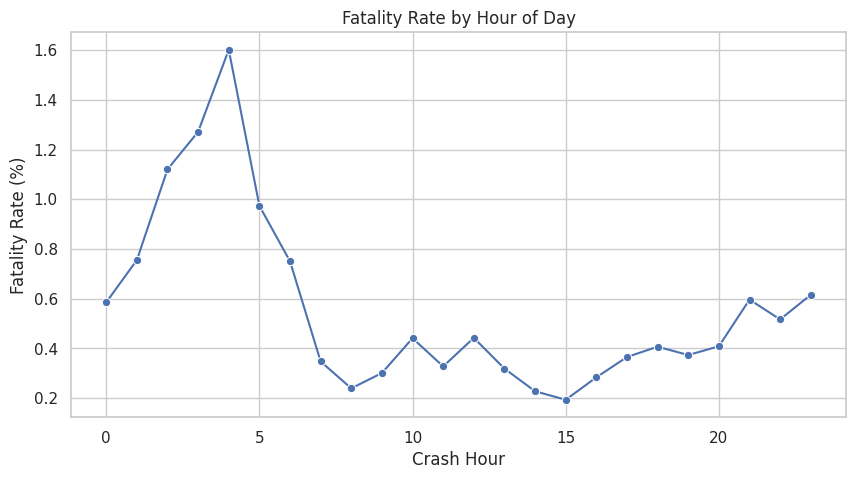

In [59]:
# STEP 6.2 | Fatality rate by hour

hourly_fatality = df_eda.groupby("CRASH_HOUR")["TARGET_FATAL"].mean() * 100

print("\nFatality rate by hour (%):")
print(hourly_fatality.round(2))

plt.figure(figsize=(10,5))
sns.lineplot(x=hourly_fatality.index, y=hourly_fatality.values, marker="o")
plt.title("Fatality Rate by Hour of Day")
plt.xlabel("Crash Hour")
plt.ylabel("Fatality Rate (%)")
plt.grid(True)
plt.show()


Fatality rate (%):
IS_WEEKEND
Weekday    0.42
Weekend    0.49
Name: TARGET_FATAL, dtype: float64


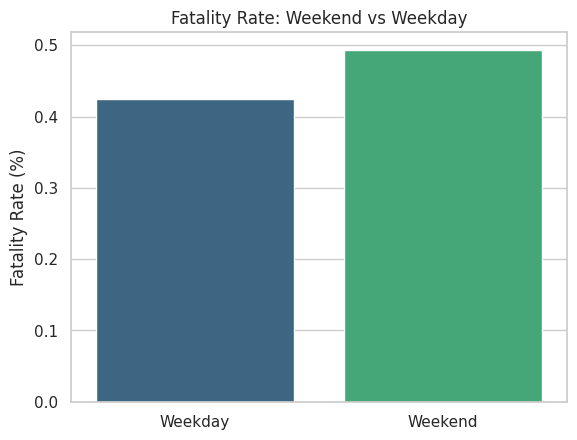

In [60]:
# STEP 6.3 | Weekend vs Weekday

weekend_severity = df_eda.groupby("IS_WEEKEND")["TARGET_FATAL"].mean() * 100

print("\nFatality rate (%):")
print(weekend_severity.rename({0: "Weekday", 1: "Weekend"}).round(2))

sns.barplot(
    x=["Weekday", "Weekend"],
    y=weekend_severity.values,
    palette="viridis"
)
plt.title("Fatality Rate: Weekend vs Weekday")
plt.ylabel("Fatality Rate (%)")
plt.show()

In [61]:
# STEP 6.4 | Pedestrian & Bicyclist Risk

vulnerable_cols = ["IS_PEDESTRIAN", "IS_BICYCLIST"]

for col in vulnerable_cols:
    rate = df_eda.groupby(col)["TARGET_FATAL"].mean() * 100
    print(f"\nFatality rate by {col}:")
    print(rate.round(2))


Fatality rate by IS_PEDESTRIAN:
IS_PEDESTRIAN
0    0.24
1    1.21
Name: TARGET_FATAL, dtype: float64

Fatality rate by IS_BICYCLIST:
IS_BICYCLIST
0    0.45
1    0.36
Name: TARGET_FATAL, dtype: float64


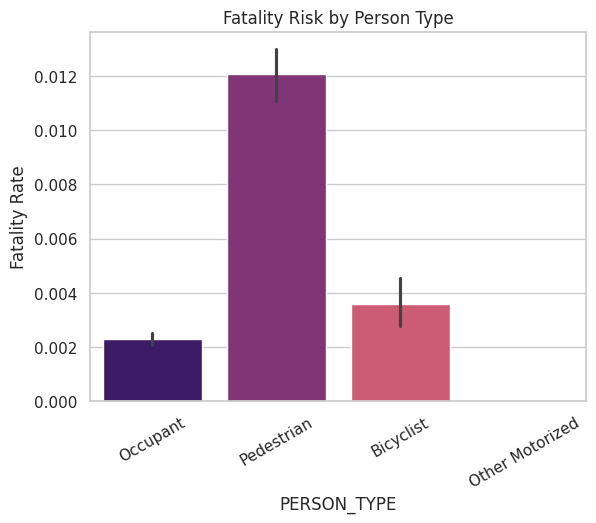

In [62]:
sns.barplot(
    data=df_eda,
    x="PERSON_TYPE",
    y="TARGET_FATAL",
    estimator=np.mean,
    palette="magma"
)
plt.title("Fatality Risk by Person Type")
plt.ylabel("Fatality Rate")
plt.xticks(rotation=30)
plt.show()

In [63]:
# STEP 6.5.1 | Create Target Variable

df_fe["TARGET_FATAL"] = (df_fe["PERSON_INJURY"] == "Killed").astype(int)

print("Target distribution:")
print(df_fe["TARGET_FATAL"].value_counts())

print("\nTarget percentage:")
print(df_fe["TARGET_FATAL"].value_counts(normalize=True) * 100)

Target distribution:
TARGET_FATAL
0    229633
1      1023
Name: count, dtype: int64

Target percentage:
TARGET_FATAL
0    99.556482
1     0.443518
Name: proportion, dtype: float64


In [64]:
# STEP 6.5.2 | Safety & Ejection

print("\nFatality rate by Ejection Risk:")
print(df_eda.groupby("EJECTION_RISK")["TARGET_FATAL"].mean() * 100)

print("\nFatality rate by No Safety Equipment:")
print(df_eda.groupby("NO_SAFETY_EQUIPMENT")["TARGET_FATAL"].mean() * 100)


Fatality rate by Ejection Risk:
EJECTION_RISK
0    0.415837
1    1.471318
Name: TARGET_FATAL, dtype: float64

Fatality rate by No Safety Equipment:
NO_SAFETY_EQUIPMENT
0    0.156490
1    0.586463
Name: TARGET_FATAL, dtype: float64


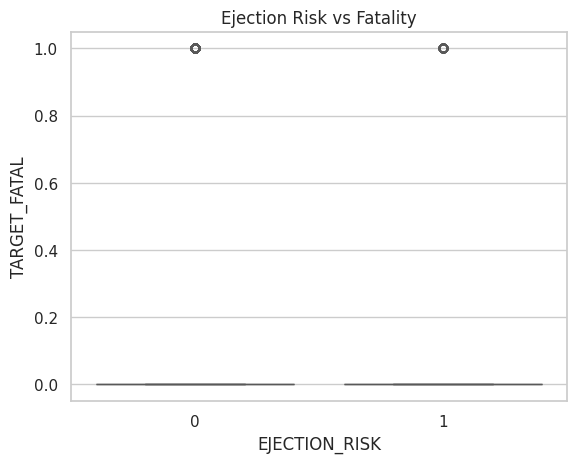

In [65]:
sns.boxplot(
    x="EJECTION_RISK",
    y="TARGET_FATAL",
    data=df_eda,
    palette="Set2"
)
plt.title("Ejection Risk vs Fatality")
plt.show()



Fatality rate by Age Group (%):
AGE_GROUP
Child          0.14
Young_Adult    0.31
Adult          0.46
Senior         1.79
Name: TARGET_FATAL, dtype: float64


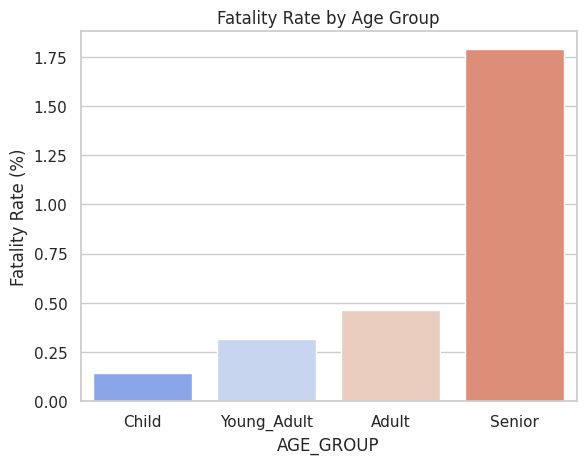

In [66]:
# STEP 6.6 | Age group analysis

age_severity = df_eda.groupby("AGE_GROUP")["TARGET_FATAL"].mean() * 100

print("\nFatality rate by Age Group (%):")
print(age_severity.round(2))

sns.barplot(
    x=age_severity.index,
    y=age_severity.values,
    palette="coolwarm"
)
plt.title("Fatality Rate by Age Group")
plt.ylabel("Fatality Rate (%)")
plt.show()


Correlation matrix (rounded):
                     PERSON_AGE  CRASH_HOUR  DAY_OF_WEEK  IS_WEEKEND  \
PERSON_AGE                 1.00       -0.02        -0.03       -0.03   
CRASH_HOUR                -0.02        1.00        -0.03       -0.05   
DAY_OF_WEEK               -0.03       -0.03         1.00        0.78   
IS_WEEKEND                -0.03       -0.05         0.78        1.00   
IS_RUSH_HOUR              -0.01        0.12        -0.09       -0.10   
IS_NIGHT                  -0.06       -0.27         0.13        0.15   
EJECTION_RISK             -0.02        0.02         0.00        0.00   
NO_SAFETY_EQUIPMENT       -0.05        0.02        -0.02       -0.02   
IS_PEDESTRIAN              0.06        0.04        -0.05       -0.06   
IS_BICYCLIST              -0.06        0.06        -0.01       -0.01   
TARGET_FATAL               0.04       -0.01         0.00        0.00   

                     IS_RUSH_HOUR  IS_NIGHT  EJECTION_RISK  \
PERSON_AGE                  -0.01     -0.0

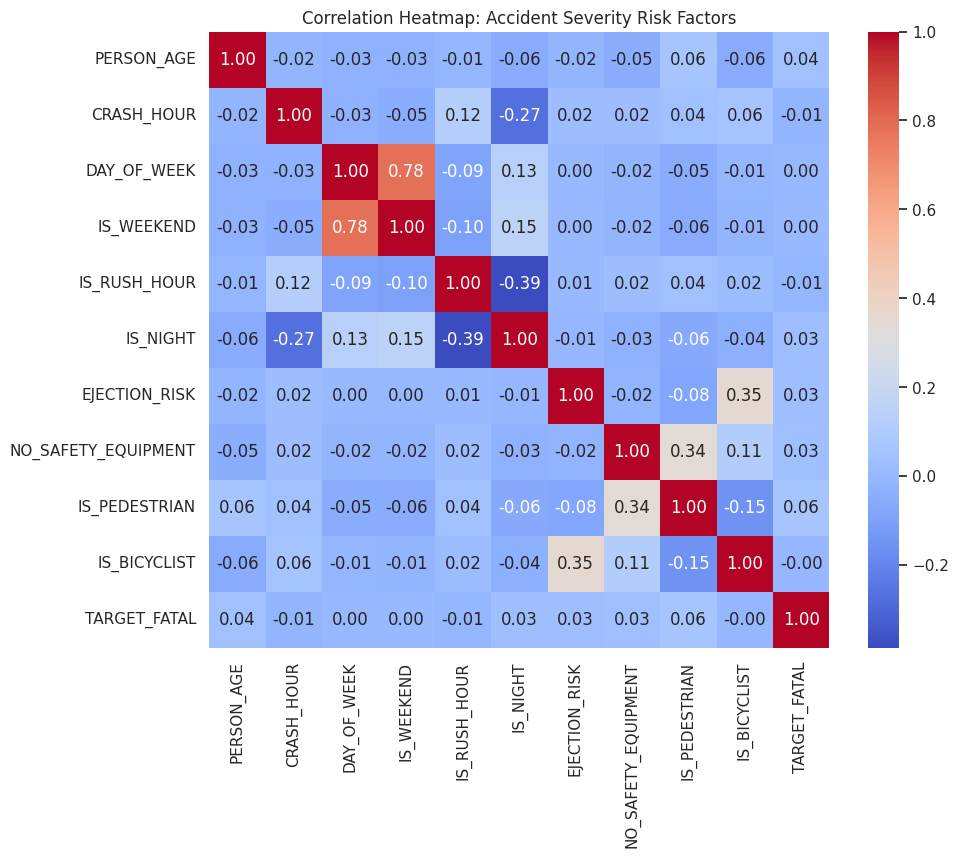

In [67]:
# STEP 6.7 | Correlation heatmap

num_cols = [
    "PERSON_AGE", "CRASH_HOUR", "DAY_OF_WEEK",
    "IS_WEEKEND", "IS_RUSH_HOUR", "IS_NIGHT",
    "EJECTION_RISK", "NO_SAFETY_EQUIPMENT",
    "IS_PEDESTRIAN", "IS_BICYCLIST", "TARGET_FATAL"
]

corr = df_eda[num_cols].corr()

print("\nCorrelation matrix (rounded):")
print(corr.round(2))

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Accident Severity Risk Factors")
plt.show()

# **STEP 7.1 | TARGET, FEATURE SELECTION & STRATIFIED SPLIT**

In [68]:
# STEP 7.1.1 | Target & Feature Selection

# Target
y = df_fe["TARGET_FATAL"]

# Selected features (generalized & safe)
feature_cols = [
    "PERSON_AGE",
    "CRASH_HOUR",
    "DAY_OF_WEEK",
    "IS_WEEKEND",
    "IS_RUSH_HOUR",
    "IS_NIGHT",
    "IS_PEDESTRIAN",
    "IS_BICYCLIST",
    "EJECTION_RISK",
    "NO_SAFETY_EQUIPMENT"
]

X = df_fe[feature_cols]

print("Feature matrix shape:", X.shape)
print("Target shape:", y.shape)

Feature matrix shape: (230656, 10)
Target shape: (230656,)


In [69]:
# STEP 7.1.2 | Stratified Split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nTrain/Test Shapes:")
print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)

print("\nTarget distribution (Train):")
print(y_train.value_counts(normalize=True) * 100)

print("\nTarget distribution (Test):")
print(y_test.value_counts(normalize=True) * 100)


Train/Test Shapes:
X_train: (184524, 10) X_test: (46132, 10)
y_train: (184524,) y_test: (46132,)

Target distribution (Train):
TARGET_FATAL
0    99.556697
1     0.443303
Name: proportion, dtype: float64

Target distribution (Test):
TARGET_FATAL
0    99.555623
1     0.444377
Name: proportion, dtype: float64


In [70]:
# STEP 7.1.3 | Baseline Logistic Regression (Imbalance-Aware)

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Pipeline
log_reg_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1
    ))
])

# Train
log_reg_pipeline.fit(X_train, y_train)

# Predict
y_pred = log_reg_pipeline.predict(X_test)
y_proba = log_reg_pipeline.predict_proba(X_test)[:, 1]

# Evaluation
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


ROC-AUC: 0.7995317064673685

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.73      0.84     45927
           1       0.01      0.75      0.02       205

    accuracy                           0.73     46132
   macro avg       0.51      0.74      0.43     46132
weighted avg       0.99      0.73      0.84     46132


Confusion Matrix:
[[33320 12607]
 [   52   153]]


In [71]:
# STEP 7.1.4 | Decision Tree Classifier

from sklearn.tree import DecisionTreeClassifier

dt_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", DecisionTreeClassifier(
        max_depth=6,              # prevent overfitting
        min_samples_leaf=200,     # stability for rare class
        class_weight="balanced",
        random_state=42
    ))
])

# Train
dt_pipeline.fit(X_train, y_train)

# Predict
y_pred_dt = dt_pipeline.predict(X_test)
y_proba_dt = dt_pipeline.predict_proba(X_test)[:, 1]

# Evaluation
print("ROC-AUC:", roc_auc_score(y_test, y_proba_dt))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_dt))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

ROC-AUC: 0.8093048512299742

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.81      0.90     45927
           1       0.02      0.65      0.03       205

    accuracy                           0.81     46132
   macro avg       0.51      0.73      0.46     46132
weighted avg       0.99      0.81      0.89     46132


Confusion Matrix:
[[37392  8535]
 [   71   134]]


In [72]:
# STEP 7.1.5 | Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestClassifier(
        n_estimators=200,
        max_depth=8,
        min_samples_leaf=100,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

# Train
rf_pipeline.fit(X_train, y_train)

# Predict
y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

# Evaluation
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_rf))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

ROC-AUC: 0.8079109105807891

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.83      0.91     45927
           1       0.02      0.66      0.03       205

    accuracy                           0.83     46132
   macro avg       0.51      0.75      0.47     46132
weighted avg       0.99      0.83      0.90     46132


Confusion Matrix:
[[38302  7625]
 [   70   135]]


In [73]:
# STEP 7.1.6 | XGBoost Classifier

!pip install xgboost
from xgboost import XGBClassifier

xgb_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", XGBClassifier(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    ))
])

# Train
xgb_pipeline.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_pipeline.predict(X_test)
y_proba_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

# Evaluation
print("ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_xgb))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))


ROC-AUC: 0.788619160735993

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.84      0.91     45927
           1       0.02      0.60      0.03       205

    accuracy                           0.84     46132
   macro avg       0.51      0.72      0.47     46132
weighted avg       0.99      0.84      0.91     46132


Confusion Matrix:
[[38499  7428]
 [   82   123]]


In [74]:
# STEP 7.1.7 | Threshold Tuning for Random Forest

from sklearn.metrics import recall_score, precision_score, f1_score

y_probs_rf = rf_pipeline.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.1, 0.9, 0.05)

results = []

for t in thresholds:
    y_pred_t = (y_probs_rf >= t).astype(int)
    recall = recall_score(y_test, y_pred_t)
    precision = precision_score(y_test, y_pred_t, zero_division=0)
    f1 = f1_score(y_test, y_pred_t)
    results.append([t, precision, recall, f1])

threshold_df = pd.DataFrame(
    results, columns=["Threshold", "Precision", "Recall", "F1"]
)

threshold_df


,Threshold,Precision,Recall,F1
0,0.10,0.005013,0.990244,0.009976
1,0.15,0.005412,0.980488,0.010765
2,0.20,0.006010,0.965854,0.011946
3,0.25,0.007335,0.897561,0.014551
4,0.30,0.008652,0.824390,0.017123
5,0.35,0.010267,0.800000,0.020273
6,0.40,0.012063,0.751220,0.023745
7,0.45,0.014494,0.702439,0.028402
8,0.50,0.017397,0.658537,0.033898
9,0.55,0.020247,0.575610,0.039118


# **STEP 8 | Evaluate Model on Seen & Unseen Data**

In [75]:
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)
import pandas as pd
import numpy as np

# Chosen threshold from tuning
THRESHOLD = 0.40

def evaluate_seen_unseen(model, X_train, y_train, X_test, y_test):

    results = []

    for split_name, X, y in [
        ("Train (Seen Data)", X_train, y_train),
        ("Test (Unseen Data)", X_test, y_test)
    ]:

        # Probability predictions
        y_probs = model.predict_proba(X)[:, 1]
        y_pred = (y_probs >= THRESHOLD).astype(int)

        roc = roc_auc_score(y, y_probs)
        precision = precision_score(y, y_pred, zero_division=0)
        recall = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)

        print(f"\n===== {split_name} PERFORMANCE =====")
        print(f"ROC-AUC : {roc:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall   : {recall:.4f}")
        print(f"F1-score : {f1:.4f}")

        print("\nClassification Report:")
        print(classification_report(y, y_pred, zero_division=0))

        print("Confusion Matrix:")
        print(confusion_matrix(y, y_pred))

        results.append([split_name, roc, precision, recall, f1])

    return pd.DataFrame(
        results,
        columns=["Dataset", "ROC_AUC", "Precision", "Recall", "F1"]
    )

# USING THE ACTUAL TRAINED MODEL
performance_df = evaluate_seen_unseen(
    model=rf_pipeline,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test
)

performance_df


===== Train (Seen Data) PERFORMANCE =====
ROC-AUC : 0.8727
Precision: 0.0136
Recall   : 0.8423
F1-score : 0.0269

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.73      0.84    183706
           1       0.01      0.84      0.03       818

    accuracy                           0.73    184524
   macro avg       0.51      0.79      0.43    184524
weighted avg       0.99      0.73      0.84    184524

Confusion Matrix:
[[133911  49795]
 [   129    689]]

===== Test (Unseen Data) PERFORMANCE =====
ROC-AUC : 0.8079
Precision: 0.0121
Recall   : 0.7512
F1-score : 0.0237

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.73      0.84     45927
           1       0.01      0.75      0.02       205

    accuracy                           0.73     46132
   macro avg       0.51      0.74      0.43     46132
weighted avg       0.99      0.73      0.84     46132

Confusion Matrix

,Dataset,ROC_AUC,Precision,Recall,F1
0,Train (Seen Data),0.872707,0.013648,0.842298,0.026861
1,Test (Unseen Data),0.807911,0.012063,0.751220,0.023745


# **STEP 9 | FINAL MODEL SELECTION & SAVING**

In [76]:
# STEP 9.1 | FINAL MODEL OBJECT

FINAL_MODEL = rf_pipeline
FINAL_THRESHOLD = 0.40

print("✅ Final Model Selected: Random Forest")
print("✅ Decision Threshold:", FINAL_THRESHOLD)

✅ Final Model Selected: Random Forest
✅ Decision Threshold: 0.4


In [77]:
# STEP 9.2 | FINAL FEATURE LIST

FINAL_FEATURES = [
    "PERSON_AGE",
    "CRASH_HOUR",
    "DAY_OF_WEEK",
    "IS_WEEKEND",
    "IS_RUSH_HOUR",
    "IS_NIGHT",
    "IS_PEDESTRIAN",
    "IS_BICYCLIST",
    "EJECTION_RISK",
    "NO_SAFETY_EQUIPMENT"
]

print("Final Features Used:")
print(FINAL_FEATURES)

Final Features Used:
['PERSON_AGE', 'CRASH_HOUR', 'DAY_OF_WEEK', 'IS_WEEKEND', 'IS_RUSH_HOUR', 'IS_NIGHT', 'IS_PEDESTRIAN', 'IS_BICYCLIST', 'EJECTION_RISK', 'NO_SAFETY_EQUIPMENT']


In [78]:
# STEP 9.3 | SAVE MODEL & METADATA

import joblib

# Save model
joblib.dump(FINAL_MODEL, "fatality_rf_model.pkl")

# Save feature list
joblib.dump(FINAL_FEATURES, "model_features.pkl")

# Save threshold
joblib.dump(FINAL_THRESHOLD, "model_threshold.pkl")

print("✅ Model saved as fatality_rf_model.pkl")
print("✅ Feature list saved as model_features.pkl")
print("✅ Threshold saved as model_threshold.pkl")

✅ Model saved as fatality_rf_model.pkl
✅ Feature list saved as model_features.pkl
✅ Threshold saved as model_threshold.pkl


In [79]:
# STEP 9.4 | FINAL SANITY CHECK

# Reload artifacts
loaded_model = joblib.load("fatality_rf_model.pkl")
loaded_features = joblib.load("model_features.pkl")
loaded_threshold = joblib.load("model_threshold.pkl")

# Test prediction on unseen data
sample_probs = loaded_model.predict_proba(X_test[loaded_features])[:, 1]
sample_preds = (sample_probs >= loaded_threshold).astype(int)

print("Sanity Check ROC-AUC:",
      roc_auc_score(y_test, sample_probs))

Sanity Check ROC-AUC: 0.8079109105807891
